<a href="https://colab.research.google.com/github/praveen83r/Banking-Recovery/blob/main/Banking_Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future (for a fixed time period such as one year). This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.

The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to contact the customer and obtain payments. Each additional level of recovery strategy requires an additional \$50 per customer so that customers in the Recovery Strategy Level 1 cost the company \$50 more than those in Level 0. Customers in Level 2 cost \$50 more than those in Level 1, etc.

The big question: does the extra amount that is recovered at the higher strategy level exceed the extra \$50 in costs? In other words, was there a jump (also called a "discontinuity") of more than \$50 in the amount recovered at the higher strategy level? We'll find out in this notebook.

In [1]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [7]:
#import the Data to the Data Frame
df = pd.read_csv('/content/bank_data.csv')

In [8]:
#chcek the data
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


2. Graphical exploratory data analysis
The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, \$3000 and \$5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between \$0 and \$2000 where the transition between Levels occurred at \$1000. We know that the customers in Level 1 (expected recovery amounts between \$1001 and \$2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between \$1 and \$1000).

Here's a quick summary of the Levels and thresholds again:

Level 0: Expected recovery amounts >\$0 and <=\$1000
Level 1: Expected recovery amounts >\$1000 and <=\$2000
The threshold of \$1000 separates Level 0 from Level 1
A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the \$1000 threshold. For example, does the customer age show a jump (discontinuity) at the \$1000 threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, \$0 to \$2000. This range covers Levels 0 and 1.

In [13]:
x = []
y = []

for i, j in zip(df['actual_recovery_amount'], df['age']):
    if i <= 2000:
        x.append(i)
        y.append(j)

x_df = pd.DataFrame({'actual_recovery_amount': x})
y_df = pd.DataFrame({'age': y})

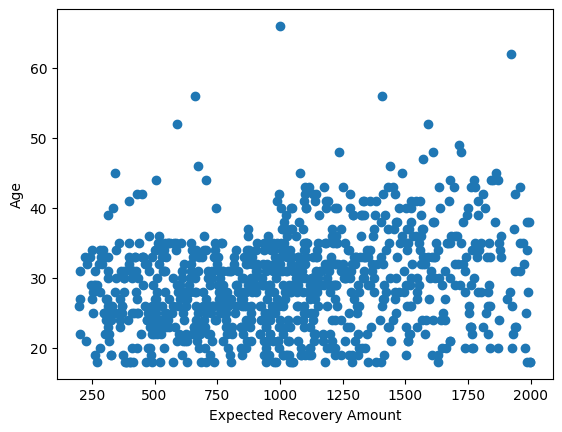

In [15]:
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.scatter(x_df,y_df)

3. Statistical test: age vs. expected recovery amount
We want to convince ourselves that variables such as age and sex are similar above and below the \$1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.

The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around \$1000. We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from \$900 to \$1100.

For determining if there is a difference in the ages just above and just below the threshold, we will use the Kruskal-Wallis test which is a statistical test that makes no distributional assumptions.

In [16]:
from scipy.stats import ttest_ind
filtered_data = df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)]
above_threshold_avg_age = filtered_data[filtered_data['expected_recovery_amount'] > 1000]['age'].mean()
below_threshold_avg_age = filtered_data[filtered_data['expected_recovery_amount'] < 1000]['age'].mean()
above_threshold_sex_distribution = filtered_data[filtered_data['expected_recovery_amount'] > 1000]['sex'].value_counts()
below_threshold_sex_distribution = filtered_data[filtered_data['expected_recovery_amount'] < 1000]['sex'].value_counts()
t_stat, p_value = ttest_ind(
    filtered_data[filtered_data['expected_recovery_amount'] > 1000]['age'],
    filtered_data[filtered_data['expected_recovery_amount'] < 1000]['age']
)

if p_value < 0.05:
    print(f"The p-value is {p_value}. The difference in age is statistically significant.")
else:
    print(f"The p-value is {p_value}. The difference in age is not statistically significant.")

The p-value is 0.10822479656694209. The difference in age is not statistically significant.


4. Statistical test: sex vs. expected recovery amount
We were able to convince ourselves that there is no major jump in the average customer age just above and just below the \$1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.

We want to also test that the percentage of customers that are male does not jump as well across the \$1000 threshold. We can start by exploring the range of \$900 to \$1100 and later adjust this range.

In [18]:
from scipy.stats import chi2_contingency
filtered_data = df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)]
contingency_table = pd.crosstab(
    filtered_data['sex'],
    filtered_data['expected_recovery_amount'] > 1000,
    margins=True
)
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

if p_value < 0.05:
    print(f"The p-value is {p_value}. There is a statistically significant association between sex and expected recovery amount.")
else:
    print(f"The p-value is {p_value}. There is no statistically significant association between sex and expected recovery amount.")
male_count = df[df['sex'] == 'Male']['sex'].count()
female_count = df[df['sex'] == 'Female']['sex'].count()

ratio_male_to_female = male_count / female_count

print(f"The ratio of male to female customers is: {ratio_male_to_female}")


The p-value is 0.9476130186712877. There is no statistically significant association between sex and expected recovery amount.
The ratio of male to female customers is: 1.0704070407040704


5. Exploratory graphical analysis: recovery amount
We are now reasonably confident that customers just above and just below the \$1000 threshold are, on average, similar in terms of their average age and the percentage that are male.

  It is now time to focus on the key outcome of interest, the actual recovery amount.

  A first step in examining the relationship between the actual recovery amount and the expected recovery amount is to develop a scatter plot where we want to focus our attention at the range just below and just above the threshold. Specifically, we will develop a scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount (X) for Expected Recovery Amounts between \$900 to \$1100. This range covers Levels 0 and 1. A key question is whether or not we see a discontinuity (jump) around the \$1000 threshold.

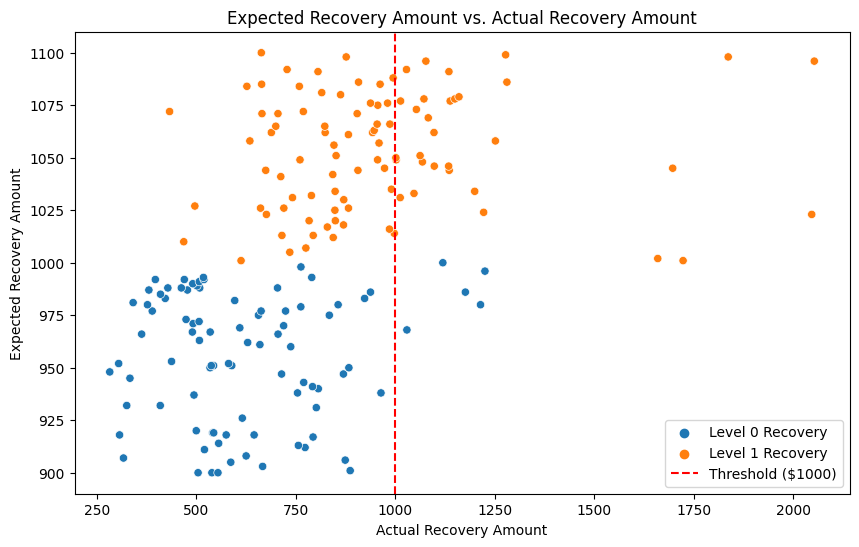

In [19]:
lower_threshold = 900
upper_threshold = 1100

# Filter data within the specified range
subset_data = df[(df['expected_recovery_amount'] >= lower_threshold) & (df['expected_recovery_amount'] <= upper_threshold)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_recovery_amount', y='expected_recovery_amount', data=subset_data, hue='recovery_strategy')
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold ($1000)')
plt.title('Expected Recovery Amount vs. Actual Recovery Amount')
plt.xlabel('Actual Recovery Amount')
plt.ylabel('Expected Recovery Amount')
plt.legend()
plt.show()

6.Statistical analysis: recovery amount
Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the $1000 threshold. We are going to do this for two different windows of the expected recovery amount $900 to $1100 and for a narrow range of $950 to $1050 to see if our results are consistent.
Again, the statistical test we will use is the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount.

In [25]:
from scipy.stats import kruskal

# Define the ranges
range_1 = df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)]
range_2 = df[(df['expected_recovery_amount'] >= 950) & (df['expected_recovery_amount'] <= 1050)]

# Perform Kruskal-Wallis test
statistic_1, p_value_1 = kruskal(range_1[range_1['expected_recovery_amount'] <= 1000]['actual_recovery_amount'],
                                range_1[range_1['expected_recovery_amount'] > 1000]['actual_recovery_amount'])

statistic_2, p_value_2 = kruskal(range_2[range_2['expected_recovery_amount'] <= 1000]['actual_recovery_amount'],
                                range_2[range_2['expected_recovery_amount'] > 1000]['actual_recovery_amount'])

print(f"Kruskal-Wallis Test (Range 900-1100):")
print(f"Statistic: {statistic_1}")
print(f"P-value: {p_value_1}")
print()

print(f"Kruskal-Wallis Test (Range 950-1050):")
print(f"Statistic: {statistic_2}")
print(f"P-value: {p_value_2}")

Kruskal-Wallis Test (Range 900-1100):
Statistic: 64.89840778685254
P-value: 7.886077128395961e-16

Kruskal-Wallis Test (Range 950-1050):
Statistic: 30.9924872487249
P-value: 2.5902913533269003e-08


7. Regression modeling: no threshold
We now want to take a regression-based approach to estimate the impact of the program at the \$1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models. The first model does not have a threshold while the second model will include a threshold.

  The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.

In [26]:
import statsmodels.api as sm
X = df['expected_recovery_amount']
Y = df['actual_recovery_amount']

# Add a constant term to the independent variable (X) for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Get the model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.817
Model:                                OLS   Adj. R-squared:                  0.817
Method:                     Least Squares   F-statistic:                     8378.
Date:                    Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                            16:33:53   Log-Likelihood:                -16936.
No. Observations:                    1882   AIC:                         3.388e+04
Df Residuals:                        1880   BIC:                         3.389e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

8.Regression modeling: adding true threshold
From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.
The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

In [27]:
# Create the indicator variable
df['above_threshold'] = (df['expected_recovery_amount'] > 1000).astype(int)
# Define the independent variables (X) and dependent variable (Y)
X = df[['expected_recovery_amount', 'above_threshold']]
Y = df['actual_recovery_amount']

# Add a constant term to the independent variables for the intercept
X = sm.add_constant(X)

# Fit the regression model
model_with_threshold = sm.OLS(Y, X).fit()

# Get the model summary
print(model_with_threshold.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.819
Model:                                OLS   Adj. R-squared:                  0.818
Method:                     Least Squares   F-statistic:                     4242.
Date:                    Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                            16:34:46   Log-Likelihood:                -16926.
No. Observations:                    1882   AIC:                         3.386e+04
Df Residuals:                        1879   BIC:                         3.387e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

9.Regression modeling: adjusting the window
The regression coefficient for the true threshold was statistically significant with an estimated impact of around $278 and a 95 percent confidence interval of $132 to $424. This is much larger than the incremental cost of running the higher recovery strategy which was $50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.
Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of $900 to $1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount. Let's repeat this analysis for the window of expected recovery amount from $950 to $1050 to see if we get similar

In [28]:
X_narrow = df[(df['expected_recovery_amount'] >= 950) & (df['expected_recovery_amount'] <= 1050)][['expected_recovery_amount', 'above_threshold']]
Y_narrow = df[(df['expected_recovery_amount'] >= 950) & (df['expected_recovery_amount'] <= 1050)]['actual_recovery_amount']

# Add a constant term to the independent variables for the intercept
X_narrow = sm.add_constant(X_narrow)

# Fit the regression model for the narrower window
model_narrow = sm.OLS(Y_narrow, X_narrow).fit()

# Get the model summary
print(model_narrow.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.270
Model:                                OLS   Adj. R-squared:                  0.255
Method:                     Least Squares   F-statistic:                     17.90
Date:                    Sat, 07 Oct 2023   Prob (F-statistic):           2.42e-07
Time:                            16:37:31   Log-Likelihood:                -700.65
No. Observations:                     100   AIC:                             1407.
Df Residuals:                          97   BIC:                             1415.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------